In [12]:
import cv2
import mediapipe as mp
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import imghdr
import os

In [16]:
data_dir = 'Emotions' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [18]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [19]:
data = tf.keras.utils.image_dataset_from_directory('Emotions')

Found 3979 files belonging to 3 classes.


In [20]:
data_iterator = data.as_numpy_iterator()

In [21]:
batch = data_iterator.next()

In [22]:
batch[1]

array([1, 2, 0, 1, 1, 2, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 1,
       0, 0, 2, 1, 0, 0, 1, 1, 2, 2])

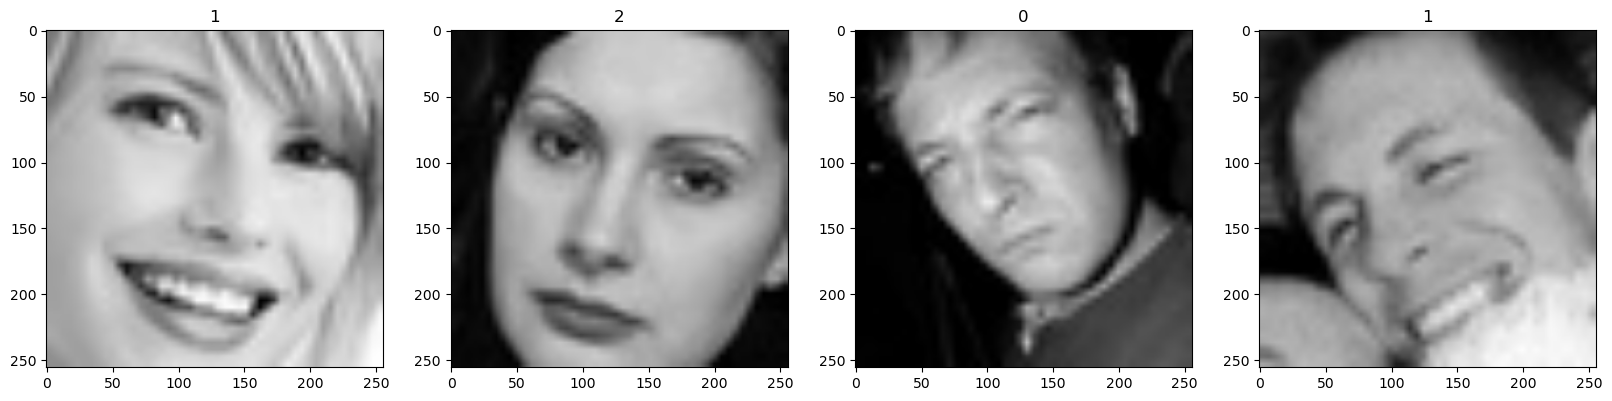

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [34]:
# Inicializar Mediapipe
mp_face_mesh = mp.solutions.face_mesh
#face_mesh = mp_face_mesh.FaceMesh()
mp_drawing = mp.solutions.drawing_utils
#mp_drawing_styles = mp.solutions.drawing_styles

with mp_face_mesh.FaceMesh(
    static_image_mode = True,
    max_num_faces=1,
    min_detection_confidence=0.5) as face_mesh:

    #Cargar la imagen
    image_path = r"Lucia.jpg"
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error al cargar la imagen desde {image_path}. Verifica la ruta y asegúrate de que el archivo exista.")
    else:
        # Convertir la imagen a RGB (Mediapipe usa RGB)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Procesar la imagen con Mediapipe
        results = face_mesh.process(image_rgb)
        
        # Convertir de nuevo a BGR para mostrar usando OpenCV
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

        print("Face Landmarks: ", results.multi_face_landmarks)

        if results.multi_face_landmarks is not None:
            for face_landmarks in results.multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    image=image_bgr,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 255), thickness=1, circle_radius=1))
                
                # Obtener coordenadas de puntos específicos
                landmarks = face_landmarks.landmark
                h, w, _ = image.shape
                
                # Puntos específicos (ajustar los índices si es necesario)
                points = [
                    (landmarks[33].x * w, landmarks[33].y * h),  # ojo izquierdo
                    (landmarks[263].x * w, landmarks[263].y * h),  # ojo derecho
                    (landmarks[2].x * w, landmarks[2].y * h),     # Base Nariz
                    (landmarks[152].x * w, landmarks[152].y * h),  # Mentón
                    (landmarks[0].x * w, landmarks[0].y * h),  # labio superior
                    (landmarks[17].x * w, landmarks[17].y * h)  # labio inferior
                ]
 
                # Convertir a enteros
                points = [(int(x), int(y)) for x, y in points]
 
                x1, y1 = points[0]
                x2, y2 = points[1]
                x3, y3 = points[2]
                x4, y4 = points[3]
                x5, y5 = points[4]
                x6, y6 = points[5]

                # Punto medio entre los ojos
                x_mid = (x1 + x2) / 2
                y_mid = (y1 + y2) / 2

                eye_distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                eye_to_nose = abs(y3 - y_mid)
                nose_to_chin = np.sqrt((x4 - x3)**2 + (y4 - y3)**2)
                mouth_distance = np.sqrt((x6 - x5)**2 + (y6 - y5)**2)
                mouth_to_chin = np.sqrt((x6 - x4)**2 + (y6 - y4)**2)

                proportion_eye_chin = nose_to_chin / eye_to_nose
                proportion_mouth_chin = mouth_to_chin / mouth_distance

                if(proportion_eye_chin >= 1.618 and proportion_mouth_chin <=1.620):
                    if(proportion_eye_chin>= 1.618 and proportion_mouth_chin <=1.620):
                        print("Cumple ocn la proporción aurea")
                
                # Mostrar resultados
                print(f'Proporción ojo-mentón: {proportion_eye_chin}')
                print(f'Proporción boca-mentón: {proportion_mouth_chin}')

                print(eye_distance, eye_to_nose, nose_to_chin,mouth_distance, )
                
                # Dibujar los puntos y las líneas
                cv2.circle(image_bgr, (x1, y1), 5, (0, 0, 255), -1)
                cv2.circle(image_bgr, (x2, y2), 5, (0, 0, 255), -1)
                cv2.circle(image_bgr, (x3, y3), 5, (0, 0, 255), -1)
                cv2.circle(image_bgr, (x4, y4), 5, (0, 0, 255), -1)
                cv2.circle(image_bgr, (x5, y5), 5, (0, 0, 255), -1)
                cv2.circle(image_bgr, (x6, y6), 5, (0, 0, 255), -1)
                cv2.circle(image_bgr, (int(x_mid), int(y_mid)), 5, (0, 0, 255), -1)
                cv2.line(image_bgr, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.line(image_bgr, (x3, y3), (x4, y4), (255, 0, 0), 2)
                cv2.line(image_bgr, (x4, y4), (x6, y6), (255, 0, 0), 2)
                cv2.line(image_bgr, (int(x_mid), int(y_mid)), (x3, y3), (255, 0, 0), 2)

        # Mostrar la imagen
        cv2.imshow('Face Mesh', image_bgr)
        cv2.waitKey(0)
    cv2.destroyAllWindows()



Face Landmarks:  [landmark {
  x: 0.509729266
  y: 0.47135967
  z: -0.0459897667
}
landmark {
  x: 0.511358321
  y: 0.42855373
  z: -0.0902829841
}
landmark {
  x: 0.510470927
  y: 0.442774892
  z: -0.0489117019
}
landmark {
  x: 0.498481572
  y: 0.383834124
  z: -0.067315951
}
landmark {
  x: 0.511896491
  y: 0.414359421
  z: -0.0958447531
}
landmark {
  x: 0.512497604
  y: 0.396320313
  z: -0.0889962837
}
landmark {
  x: 0.51383692
  y: 0.354148149
  z: -0.0418579429
}
landmark {
  x: 0.393578827
  y: 0.353933036
  z: 0.0223076828
}
landmark {
  x: 0.515022
  y: 0.318306118
  z: -0.0278937407
}
landmark {
  x: 0.515743792
  y: 0.299474776
  z: -0.030509267
}
landmark {
  x: 0.51833576
  y: 0.244833753
  z: -0.012614592
}
landmark {
  x: 0.509505928
  y: 0.477579892
  z: -0.0432698913
}
landmark {
  x: 0.509323835
  y: 0.481583774
  z: -0.0380990468
}
landmark {
  x: 0.509235084
  y: 0.482341707
  z: -0.0310468208
}
landmark {
  x: 0.508796751
  y: 0.481971264
  z: -0.0341540501
}
lan